In [1]:
from fastai import *
from fastai.text import * 
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    if use_cuda: 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False
        
random_seed(42, True)

In [3]:
# bring en files (all then filter)
!wget https://raw.githubusercontent.com/abedkhooli/ds2/master/ulmfit2/prepare_xnli.sh 

--2021-06-13 07:59:04--  https://raw.githubusercontent.com/abedkhooli/ds2/master/ulmfit2/prepare_xnli.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 772 [text/plain]
Saving to: ‘prepare_xnli.sh.1’

prepare_xnli.sh.1   100%[===================>]     772  --.-KB/s    in 0s      

2021-06-13 07:59:04 (34.2 MB/s) - ‘prepare_xnli.sh.1’ saved [772/772]



In [6]:
filename_dev = 'xnli.dev.tsv'
filename_test = 'xnli.test.tsv'
df_dev = pd.read_csv(filename_dev, delimiter='\t', quoting=csv.QUOTE_NONE)
df_test = pd.read_csv(filename_test, delimiter='\t', quoting=csv.QUOTE_NONE)
len(df_dev), len(df_test)

(37350, 75150)

In [7]:
df_dev_en= df_dev[df_dev['language']=='en']
df_test_en= df_test[df_test['language']=='en']
len(df_dev_en), len(df_test_en)
# Each language has 2490 dev samples and 5010 test samples (from readme).

(2490, 5010)

In [8]:
df_dev_en = df_dev_en[['gold_label','sentence1_tokenized', 'sentence2_tokenized']]
df_test_en = df_test_en[['gold_label','sentence1_tokenized', 'sentence2_tokenized']]
df_dev_en['is_valid'] = False
df_test_en['is_valid'] = True
df_test_en.head()

,gold_label,sentence1_tokenized,sentence2_tokenized,is_valid
20040,contradiction,"Well , I wasn 't even thinking about that , bu...",I havent spoken to him again .,True
20041,entailment,"Well , I wasn 't even thinking about that , bu...",I was so upset that I just started talking to ...,True
20042,neutral,"Well , I wasn 't even thinking about that , bu...",We had a great talk .,True
20043,neutral,"And I thought that was a privilege , and it 's...",I was not aware that I was not the only person...,True
20044,entailment,"And I thought that was a privilege , and it 's...",I was under the impression that I was the only...,True


In [9]:
df_all = pd.concat([df_dev_en,df_test_en])
df_all['gold_label'].value_counts()

entailment       2500
neutral          2500
contradiction    2500
Name: gold_label, dtype: int64

In [10]:
# create a data folder and copy train and test data into it 
Path('data/xnli_en/').mkdir(parents=True, exist_ok=True)
df_all.to_csv('data/xnli_en/xnli_text.csv', index=False)

In [11]:
processor = [TokenizeProcessor(mark_fields=True), NumericalizeProcessor(max_vocab=60000)]

In [12]:
path = Path('data/xnli_en/')
path.ls()

[PosixPath('data/xnli_en/xnli_text.csv')]

In [13]:
data_lm = (TextList.from_csv(path, 'xnli_text.csv', cols=['sentence1_tokenized', 'sentence2_tokenized'],processor = processor)
                   .random_split_by_pct()
                   .label_for_lm()
                   .databunch())
data_lm.save()

/usr/local/lib/python3.7/dist-packages/fastai/data_block.py:217: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


In [14]:
data_lm.show_batch(10)

idx,text
0,", so was to report to a designated place in xxmaj washington . xxfld 2 i have never been to xxmaj washington so when i was assigned there i got lost trying to find the place . xxbos xxfld 1 i didn ' t know what i was going for or anything , so was to report to a designated place in xxmaj washington . xxfld 2 i knew exactly"
1,"able to do it on my own . xxbos xxfld 1 xxmaj well , there 's nobody there to help me . xxfld 2 xxmaj there are plenty of people to help me there . xxbos xxfld 1 xxmaj well , there 's nobody there to help me . xxfld 2 xxmaj there isn ' t anyone in that place to assist me . xxbos xxfld 1 xxmaj the xxup"
2,any good really i don ' t think xxfld 2 i think you have to xxunk 10 hours a day to be good at it . xxbos xxfld 1 exactly it 's it 's an active state it 's not something that you can kind of you know be passively involved in and expect to do any good really i don ' t think xxfld 2 i think you need
3,"xxmaj it 's everyone involved in the legal system . xxbos xxfld 1 not just lawyers but police officers and judges and the whole legal profession in general xxfld 2 xxmaj most of the legal system is involved , a majority being that of police . xxbos xxfld 1 and uh that was twenty five hundred people when i joined and uh xxfld 2 xxmaj at the time that i"
4,"address narrative organization ( xxmaj what happens next ? xxfld 2 xxmaj five year olds are concerned with what happens next . xxbos xxfld 1 xxmaj for 4- and 5-year - olds , questions more often address narrative organization ( xxmaj what happens next ? xxfld 2 xxmaj five year olds are generally considered poor xxunk . xxbos xxfld 1 xxmaj intuitively , slightly convergent flow in state space allows"
5,"tower , he suggests to xxmaj vance , pointing to a corner by a bookshelf . xxfld 2 xxmaj someone is talking to xxmaj vance . xxbos xxfld 1 i turn , in the final section of this chapter , to yet another puzzle concerning what i call a natural game . xxfld 2 i could not address the natural game in this chapter . xxbos xxfld 1 i turn"
6,"tainted with a crime . xxbos xxfld 1 xxmaj he was allowed plainly to perceive that it was the graceful , elegant young xxunk from xxmaj st. xxmaj james 's , xxmaj lord xxmaj julian xxmaj wade , to whom her every moment was xxunk . xxfld 2 xxmaj lord xxmaj julian is from xxmaj st. xxmaj james 's . xxbos xxfld 1 xxmaj but ... but ... aboard this"
7,trim figure in grey xxunk that was xxunk the companion . xxfld 2 xxmaj he has only one eye . xxbos xxfld 1 xxmaj out of the tail of his single eye he had xxunk a trim figure in grey xxunk that was xxunk the companion . xxfld 2 xxmaj he only has a left eye . xxbos xxfld 1 xxmaj no . xxmaj blood closed his telescope . xxfld
8,"the xxmaj south xxmaj african xxmaj area . xxbos xxfld 1 xxmaj behind the xxmaj south xxmaj american area you 'll find the xxmaj perfume xxmaj factory , where you can create your own personal xxunk . xxfld 2 ` xxmaj the xxmaj perfume xxmaj factory is in front of the xxmaj south xxmaj african area . xxbos xxfld 1 xxmaj hopes were raised , and also xxunk , over"
9,"xxmaj national xxmaj historical xxmaj museum has a lot of artifacts from post - xxmaj classical times . xxbos xxfld 1 xxmaj nearer to xxmaj syntagma , in xxmaj koloktroni xxmaj square , is the xxmaj national xxmaj historical xxmaj museum with a collection of artifacts dating from post - xxmaj classical times . xxfld 2 xxmaj the xxmaj national xxmaj historical xxmaj museum has some old farm equipment ."


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


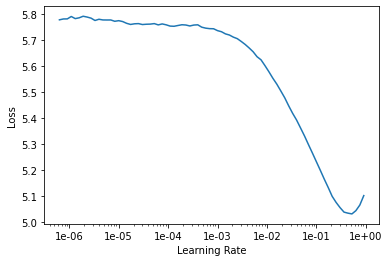

In [20]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)
#learn = language_model_learner(data_lm, pretrained_model=AWD_LSTM, drop_mult=0.1)
learn.lr_find()
learn.recorder.plot(skip_end=12)

In [21]:
learn.fit_one_cycle(1, 4e-2) # was 10 

epoch,train_loss,valid_loss,accuracy,time
0,3.826046,3.016315,0.417698,05:16


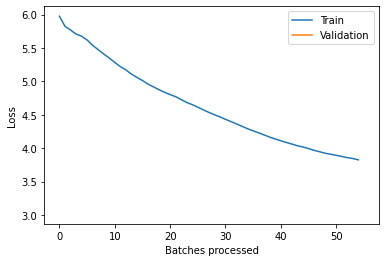

In [22]:
learn.recorder.plot_losses()

In [23]:
# first amount of words (here 10), the next 10 target words (actual) and the ones predicted.
learn.show_results(max_len = 10)

text,target,pred
"xxbos xxfld 1 xxmaj about him in the waist ,","where all last night had been so peaceful , there","he he the xxmaj 's been , xxunk , the"
political justice . xxfld 2 xxmaj our nation is built,on the grounds of social and political justice . xxbos,by the same of the equality economic rights . xxbos
. xxfld 2 i told him i didn ' t,want to hear anything else . xxbos xxfld 1 xxmaj,know to be him . . xxbos xxfld 1 xxmaj
xxunk voice xxfld 2 i know that voice xxbos xxfld,1 well i don ' t have kids so it,1 xxmaj i have ' t know to . i
xxunk windows . xxfld 2 xxmaj the church looks like,xxmaj xxunk style . xxbos xxfld 1 xxmaj the xxunk,a the xxmaj . xxbos xxfld 1 xxmaj the xxmaj


In [24]:
learn.save('mini_train_lm')
learn.save_encoder('mini_train_encoder')

In [25]:
data_clas = (TextList.from_csv(path, 'xnli_text.csv', cols=['sentence1_tokenized', 'sentence2_tokenized'],processor = processor, vocab=data_lm.vocab)
                   .split_from_df(col='is_valid')
                   .label_from_df(cols='gold_label')
                   .databunch(bs=42))

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [26]:
data_clas.show_batch()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


text,target
"xxbos xxfld 1 xxmaj between 6 : 45 and 7 : 40 , xxmaj atta and xxmaj omari , along with xxmaj xxunk al xxmaj xxunk , xxmaj wail al xxmaj shehri , and xxmaj xxunk al xxmaj shehri , checked in and boarded xxmaj american xxmaj airlines xxmaj flight 11 , bound for xxmaj los xxmaj angeles . xxfld 2 xxmaj they attempted to board the flight but xxmaj",contradiction
"xxbos xxfld 1 xxmaj don ' t you , by xxmaj god ! xxmaj and what else do you call this ? xxmaj but as xxmaj his xxmaj majesty 's xxmaj deputy - xxmaj governor of xxmaj jamaica , i 'll take leave to correct your mistake in my own way . xxfld 2 xxmaj one man told the other that he had done his work perfectly and that any",contradiction
"xxbos xxfld 1 a renowned proponent of xxmaj mexican xxmaj spanish folklore in the xxmaj southwest and xxmaj california was xxmaj charles xxup f. xxmaj lummis ( 1859 - 1928 ) , a self - taught photographer , ethnologist , musicologist , journalist , and the founder of the xxmaj southwest xxmaj museum in xxmaj los xxmaj angeles . xxfld 2 xxmaj charles xxup f. xxmaj lummis was a photographer",entailment
"xxbos xxfld 1 xxmaj thus , on average , xxmaj webster 's xxmaj xxunk xxmaj new xxmaj xxunk and the xxmaj random xxmaj house xxmaj webster 's xxmaj college contain at least fifteen per cent more information per entry than xxmaj american xxmaj heritage and xxmaj webster 's xxmaj new xxmaj world . xxfld 2 xxmaj webster 's xxmaj college is missing way more information than the other books .",contradiction
"xxbos xxfld 1 a renowned proponent of xxmaj mexican xxmaj spanish folklore in the xxmaj southwest and xxmaj california was xxmaj charles xxup f. xxmaj lummis ( 1859 - 1928 ) , a self - taught photographer , ethnologist , musicologist , journalist , and the founder of the xxmaj southwest xxmaj museum in xxmaj los xxmaj angeles . xxfld 2 xxmaj charles xxup f. xxmaj lummis was funny .",neutral


In [28]:
learn_clas = text_classifier_learner(data_clas,AWD_LSTM, drop_mult=0.5)
# learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

learn_clas.load_encoder('mini_train_encoder')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (2490 items)
x: TextList
xxbos xxfld 1 xxmaj and he said , xxmaj mama , i ' m home . xxfld 2 xxmaj he called his mom as soon as the school bus dropped him off .,xxbos xxfld 1 xxmaj and he said , xxmaj mama , i ' m home . xxfld 2 xxmaj he didn ' t say a word .,xxbos xxfld 1 xxmaj and he said , xxmaj mama , i ' m home . xxfld 2 xxmaj he told his mom he had gotten home .,xxbos xxfld 1 i didn ' t know what i was going for or anything , so was to report to a designated place in xxmaj washington . xxfld 2 i have never been to xxmaj washington so when i was assigned there i got lost trying to find the place .,xxbos xxfld 1 i didn ' t know what i was going for or anything , so was to report to a designated place in xxmaj washington . xxfld 2 i knew exactly what i needed to do as i xxunk to xxmaj washington .
y: CategoryList
neutral,contradiction,entailment,neutral,contradiction
Path: data/xnli_en;

Valid: LabelList (5010 items)
x: TextList
x

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


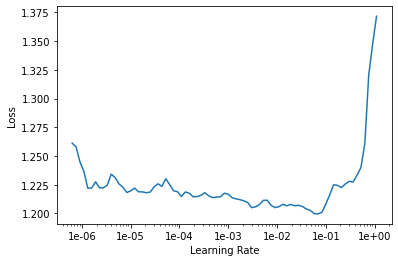

In [29]:
learn_clas.lr_find() # start_lr=1e-15, end_lr=1e2
learn_clas.recorder.plot() # skip_end=4

In [30]:
learn_clas.fit_one_cycle(4, 4e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.200092,1.110935,0.379042,03:03
1,1.129202,1.078464,0.396008,03:06
2,1.098448,1.067889,0.419760,03:13
3,1.082921,1.066270,0.412176,03:08


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

In [31]:
learn_clas.show_results()

text,target,prediction
"xxbos xxfld 1 xxmaj in 1972 , xxmaj phillip xxmaj morris , xxmaj inc . ' s xxmaj miller xxmaj brewing xxmaj co. acquired the xxmaj lite beer label in a buyout of xxmaj meister xxmaj brau xxmaj inc . xxfld 2 xxmaj phillip xxmaj morris , xxmaj inc . ' s xxmaj miller xxmaj brewing xxmaj co. decided it didn ' t want the xxmaj lite beer label as",contradiction,contradiction
"xxbos xxfld 1 xxmaj deborah xxmaj cameron and xxmaj deborah xxmaj hills ( ` xxmaj listening in ' : xxunk relationships between xxunk and xxunk on radio phone - in programmes ) have studied the xxunk of xxup lbc xxmaj radio , xxmaj london 's all - talk station , which i have listened to with interest . xxfld 2 xxmaj deborah xxmaj cameron and xxmaj deborah xxmaj hills have",neutral,contradiction
"xxbos xxfld 1 xxmaj two days later , xxmaj ahmed al xxmaj ghamdi and xxmaj abdul xxmaj aziz al xxmaj omari , who had been living in xxmaj new xxmaj jersey with xxmaj hazmi and xxmaj hanjour , flew to xxmaj miami - probably xxunk that the four hijacking teams had finally been assigned . xxfld 2 xxmaj ahmed al xxmaj ghamdi , xxmaj abdul xxmaj aziz al xxmaj omari",entailment,entailment
"xxbos xxfld 1 xxmaj two days later , xxmaj ahmed al xxmaj ghamdi and xxmaj abdul xxmaj aziz al xxmaj omari , who had been living in xxmaj new xxmaj jersey with xxmaj hazmi and xxmaj hanjour , flew to xxmaj miami - probably xxunk that the four hijacking teams had finally been assigned . xxfld 2 xxmaj ahmed al xxmaj ghamdi and xxmaj abdul xxmaj aziz al xxmaj omari",contradiction,entailment
"xxbos xxfld 1 xxmaj but if he uses the xxunk , xxunk , and idiom of the standard xxmaj english found in newspapers , books , magazines , and news xxunk , then all we notice about his speech is his accent -- and possibly his xxunk . xxfld 2 xxmaj he is using standard xxmaj english xxunk and vocabulary found in newspapers , books , and magazines in an",neutral,contradiction


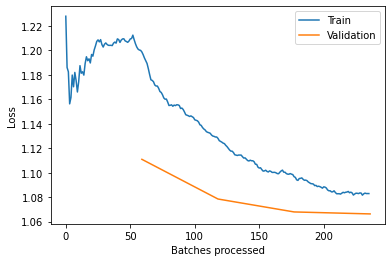

In [32]:
learn_clas.recorder.plot_losses()

In [39]:
import os 
learn_clas.save(os.getcwd()+'mini_train_clas')

In [40]:
# not the right way to pass 2 cols, need to apply proc
learn_clas.predict("I went shoping. No, I did not go to the shop.")
#contradiction

(Category tensor(0), tensor(0), tensor([0.4015, 0.3981, 0.2004]))

In [37]:
learn_clas.predict("I went shoping. I did go to shop.")

(Category tensor(1), tensor(1), tensor([0.2979, 0.4767, 0.2254]))

In [41]:
#train for 10 epochs
learn_clas.fit_one_cycle(10, 4e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.071561,1.059282,0.436128,03:15
1,1.076197,1.060523,0.441916,03:15
2,1.087254,1.067921,0.417964,03:15
3,1.087580,1.058756,0.441916,03:10
4,1.080825,1.060227,0.427545,03:13
5,1.075503,1.052803,0.442715,03:15
6,1.061522,1.047005,0.449301,03:15
7,1.056694,1.037675,0.457485,03:08
8,1.048422,1.035503,0.467665,03:12
9,1.042188,1.034455,0.469062,03:10


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar